# The data

The data is a list of article metadata from NYT for the month of January through
the years 2013 to 2024. The data is in JSON format. 

Our goal is to import all the saved data and create a pandas DataFrame with it.
This will let us analyze the data and answer questions like:

- Trends in article topics over the last 10 years
- Most popular authors
- Most popular sections
- Most popular keywords
- Most popular articles
- and so on...

In [2]:
import json
import requests
import time
import os
from dotenv import dotenv_values

config = dotenv_values(".env")

API_KEY = config['API_KEY']

In [ ]:
def get_nyt_articles(year, month):
    url = f'https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={API_KEY}'
    response = requests.get(url)
    response.raise_for_status()
    # return only the articles. The response object contains metadata as well.
    return response.json()['response']['docs']

def build_nyt_archive():
    articles = []
    month = 1
    for year in range(2014, 2025):
        articles.extend(get_nyt_articles(year, month))
        print(f'Fetched {len(articles)} articles total.')
        time.sleep(20)
    return articles

def save_nyt_archive(articles):
    # check if the data folder exists, if not, create it
    if not os.path.exists('data'):
        os.makedirs('data')
    with open('data/nyt_archive_2014_2024_jan.json', 'w') as f:
        json.dump(articles, f)

articles = build_nyt_archive()
save_nyt_archive(articles)
print('NYT archive saved to nyt_archive_2013_2023_jan.json')

Fetched 7337 articles total.


In [3]:
def load_json():
    with open('data/nyt_archive_2013_2024_jan.json', 'r') as f:
        return json.load(f)
    
articles = load_json()
print(len(articles))
print(articles[0])

57364
{'abstract': 'Other than the national championship game, the Rose Bowl offers the most anticipated matchup of the season, but the Capital One Bowl and Fiesta Bowl should also be intriguing.', 'web_url': 'https://www.nytimes.com/2014/01/01/sports/ncaafootball/new-years-day-bowl-games.html', 'snippet': 'Other than the national championship game, the Rose Bowl offers the most anticipated matchup of the season, but the Capital One Bowl and Fiesta Bowl should also be intriguing.', 'lead_paragraph': 'ROSE BOWL', 'print_section': 'B', 'print_page': '10', 'source': 'The New York Times', 'multimedia': [{'rank': 0, 'subtype': 'xlarge', 'caption': None, 'credit': None, 'type': 'image', 'url': 'images/2014/01/01/sports/Y-games/Y-games-articleLarge.jpg', 'height': 318, 'width': 600, 'subType': 'xlarge', 'crop_name': 'articleLarge', 'legacy': {'xlarge': 'images/2014/01/01/sports/Y-games/Y-games-articleLarge.jpg', 'xlargewidth': 600, 'xlargeheight': 318}}, {'rank': 0, 'subtype': 'jumbo', 'capti

In [4]:
# Exploration

# Each article is a dictionary with multiple keys. Some of the values are
# dictionaries themselves. For example, the 'headline' key has a dictionary
# as its value. The 'keywords' key has a list of dictionaries as its value.

# keys of the articles dictionary
print(articles[0].keys())

# keys of the headline dictionary
print(articles[0]['headline'].keys())

# keys of the first keyword dictionary
print(articles[0]['keywords'][0].keys())

# multimedia is a list of dictionaries for the multimedia content of the article
# count of the multimedia content of the first article
print(len(articles[0]['multimedia']))

# the data I think we should keep from the articles dictionary is:
# abstract, byline (Author Name), document_type, headline, keywords, news_desk, section_name, word_count, 

# print the data in the keywords field
print(articles[0]['keywords'])

# print the data in the headline field
print(articles[0]['headline'])

# print the data in the byline field
print(articles[0]['byline'])



dict_keys(['abstract', 'web_url', 'snippet', 'lead_paragraph', 'print_section', 'print_page', 'source', 'multimedia', 'headline', 'keywords', 'pub_date', 'document_type', 'news_desk', 'section_name', 'subsection_name', 'byline', 'type_of_material', '_id', 'word_count', 'uri'])
dict_keys(['main', 'kicker', 'content_kicker', 'print_headline', 'name', 'seo', 'sub'])
dict_keys(['name', 'value', 'rank', 'major'])
5
[{'name': 'persons', 'value': 'Bierman, Fred', 'rank': 1, 'major': 'N'}, {'name': 'subject', 'value': 'Rose Bowl (Football Game)', 'rank': 2, 'major': 'N'}, {'name': 'subject', 'value': 'Football (College)', 'rank': 3, 'major': 'N'}, {'name': 'organizations', 'value': 'Stanford University', 'rank': 4, 'major': 'N'}, {'name': 'organizations', 'value': 'Michigan State University', 'rank': 5, 'major': 'N'}, {'name': 'subject', 'value': 'Fiesta Bowl', 'rank': 6, 'major': 'N'}, {'name': 'organizations', 'value': 'University of South Carolina', 'rank': 7, 'major': 'N'}, {'name': 'organ

# Creating dataframes

We will create a pandas DataFrame from the data based on the fields we've
decided to keep.

In [5]:
import pandas as pd
import numpy as np


def extract_main_author(byline):
    """Extracts the name of the person with rank 1 from the byline."""
    if 'person' in byline and byline['person']:
        # Look for the person with rank 1
        for person in byline['person']:
            if person.get('rank') == 1:
                # Format the name as 'Firstname Lastname'
                return f"{person.get('firstname', '')} {person.get('lastname', '')}".strip()
    # If no rank 1 person is found, return NaN
    return np.nan


def extract_keywords_with_subcategories(article):
    """Extracts keywords and keeps the first rank as main and second rank as subcategory."""
    keyword_dict = {}
    
    # Initialize lists to hold keywords by type
    subjects = []
    organizations = []
    glocations = []
    persons = []

    # Iterate over keywords and categorize them
    for keyword in article.get('keywords', []):
        keyword_type = keyword['name']
        keyword_value = keyword['value']
        
        # Append the keyword to the appropriate list
        if keyword_type == 'subject':
            subjects.append(keyword_value)
        elif keyword_type == 'organizations':
            organizations.append(keyword_value)
        elif keyword_type == 'glocations':
            glocations.append(keyword_value)
        elif keyword_type == 'persons':
            keyword_dict['person'] = keyword_value

    # Assign the first and second ranked keywords for each type
    if subjects:
        keyword_dict['subject'] = subjects[0]  # First ranked subject
        keyword_dict['subject_subcategory'] = subjects[1] if len(subjects) > 1 else np.nan  # Second ranked subject

    if organizations:
        keyword_dict['organization'] = organizations[0]  # First ranked organization
        keyword_dict['organization_subcategory'] = organizations[1] if len(organizations) > 1 else np.nan  # Second ranked organization

    if glocations:
        keyword_dict['glocation'] = glocations[0]  # First ranked glocation
        keyword_dict['glocation_subcategory'] = glocations[1] if len(glocations) > 1 else np.nan  # Second ranked glocation

    if persons:
        keyword_dict['person'] = persons[0]
        keyword_dict['person_subcategory'] = persons[1] if len(persons) > 1 else np.nan

    return keyword_dict

articles_data = []
for article in articles:
    article_data = {
        'headline': article['headline']['main'],
        'pub_date': article['pub_date'],
        'document_type': article['document_type'],
        'word_count': article.get('word_count', 0),
        'news_desk': article.get('news_desk'),
        'section_name': article.get('section_name'),
        'type_of_material': article.get('type_of_material'),
        'multimedia_count': len(article.get('multimedia', [])),
        'author': extract_main_author(article.get('byline', {})),
    }
    # Add the keywords with subcategories
    article_data.update(extract_keywords_with_subcategories(article))

    articles_data.append(article_data)

# Create DataFrame
df = pd.DataFrame(articles_data)

df.to_csv('data/raw.csv', index=False)

In [6]:
# count the null values in each row and add a new column to the dataframe for
# the count of null values.
df['null_count'] = df.isnull().sum(axis=1)

# sort the dataframe by the number of null values in each row
df = df.sort_values('null_count', ascending=True)

# convert the all entries in the whole dataframe to title case
df = df.apply(lambda x: x.str.title() if x.dtype == "object" else x)

# drop the rows with more than 2 null values
df = df[df['null_count'] <= 2]

# drop the null_count column
df = df.drop(columns='null_count')

# save the cleaned data to a new csv file
df.to_csv('data/cleaned.csv', index=False)

# Date cleaning

The date column is a string. We can use regex to extract the year, month, and
day from the date and put them in their own columns.

In [7]:
# date cleaning
# convert the pub_date column to a datetime object
df['pub_date'] = pd.to_datetime(df['pub_date'])

# get the year, month, and day from the pub_date column
df['year'] = df['pub_date'].dt.year
df['month'] = df['pub_date'].dt.month
df['day'] = df['pub_date'].dt.day

# drop the pub_date column
df = df.drop('pub_date', axis=1)

# save the cleaned data to a new CSV file
df.to_csv('data/cleaned.csv', index=False)

## Headline Apostrophe Cleaning

In [8]:
# Cleaning text encoding in the 'headline' column

df['headline'] = df['headline'].str.replace(r'[\u2018\u2019]', "'", regex=True)

df['headline'] = df['headline'].str.replace("'S ", "'s ")

df.to_csv('data/cleaned.csv', encoding='utf-8', index=False)

## Persons cleaning

In [9]:
df['person'] = df['person'].str.replace(r"\s*\(.*\)", "", regex=True)

# # Switch from 'Lastname, Firstname MiddleInitial' to 'Firstname MiddleInitial Lastname'
df['person'] = df['person'].str.replace(
    r"(\w+),\s*(\w+)(\s+\w)?", r"\2\3 \1", regex=True)

## Keywords cleaning

In [10]:
df['subject'] = df['subject'].str.replace(r"\s*\(.*\)", "", regex=True)

df['subject_subcategory'] = df['subject_subcategory'].str.replace(r"\s*\(.*\)", "", regex=True)

df['organization'] = df['organization'].str.replace(r"\s*\(.*\)", "", regex=True)

df['organization_subcategory'] = df['organization_subcategory'].str.replace(r"\s*\(.*\)", "", regex=True)

df['type_of_material'] = df['type_of_material'].str.replace(r"\s*\(.*\)", "", regex=True)



df.to_csv('data/cleaned.csv', encoding='utf-8', index=False)

## EDA

In [11]:
# Exploratory Data Analysis

# mean of the word_count column
print(df['word_count'].mean())

# median of the word_count column
print(df['word_count'].median())

# mode of the word_count column
print(df['word_count'].mode())

# standard deviation of the word_count column
print(df['word_count'].std())

# maximum of the word_count column
print(df['word_count'].max())

# minimum of the word_count column
print(df['word_count'].min())

# range of the word count column
print(df['word_count'].max() - df['word_count'].min())

996.4293875189818
948.0
0    0
Name: word_count, dtype: int64
614.1419013313209
11987
0
11987


In [12]:
print(df['document_type'].unique())

# if document_type is multimedia, set word_count to null
df.loc[df['document_type'] == 'Multimedia', 'word_count'] = np.nan


# mean of the word_count column
print(df['word_count'].mean())

# median of the word_count column
print(df['word_count'].median())

# mode of the word_count column
print(df['word_count'].mode())

# standard deviation of the word_count column
print(df['word_count'].std())

# maximum of the word_count column
print(df['word_count'].max())

# minimum of the word_count column
print(df['word_count'].min())

# range of the word count column
print(df['word_count'].max() - df['word_count'].min())

['Article' 'Multimedia']
1011.4968802760038
957.0
0    1043.0
Name: word_count, dtype: float64
606.326832524011
11987.0
1.0
11986.0


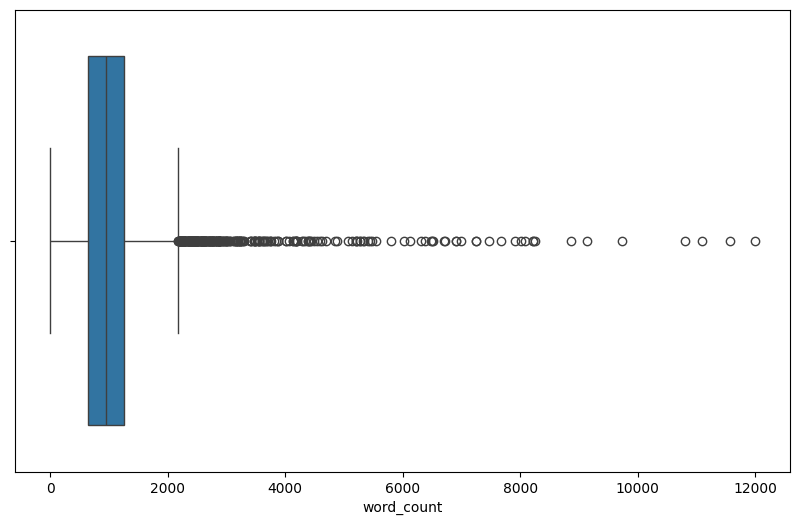

303


In [13]:
#find outliers in the word count by plotting it
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['word_count'])
plt.show()

# count the number of outliers based on the boxplot
q1 = df['word_count'].quantile(0.25)
q3 = df['word_count'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['word_count'] < lower_bound) | (df['word_count'] > upper_bound)]
print(len(outliers))
# print(outliers)



In [14]:
# print all the unique values in all the columns of the dataframe
# exclude the headline, word_count columns
# for column in df.columns:
#     if column not in ['headline', 'word_count']:
#         print(f'{column}: {df[column].unique()}')
# for column in df.columns:
    # print(f'{column}: {df[column].unique()}')
print(df['section_name'].value_counts())

World                          2940
U.S.                           2858
New York                       1490
Business Day                   1464
Opinion                        1279
Arts                            844
Sports                          803
Technology                      308
Science                         198
Health                          136
Food                            127
Theater                         108
Fashion & Style                 103
Travel                          100
Magazine                         96
Style                            93
Books                            89
Multimedia/Photos                84
Blogs                            80
Climate                          75
Obituaries                       72
T Magazine                       72
Real Estate                      64
Movies                           51
Podcasts                         43
Briefing                         43
Automobiles                      41
The Upshot                  

In [32]:
print(df['news_desk'].value_counts())

print("unique news desks: ", len(df['news_desk'].unique()))

Foreign                     2756
Business                    1546
Metro                       1357
National                    1106
Oped                        1004
                            ... 
Well                           1
Technology                     1
Projects And Initiatives       1
Media                          1
Food                           1
Name: news_desk, Length: 64, dtype: int64
unique news desks:  64


Foreign                     2756
Business                    1546
Metro                       1357
National                    1106
Oped                        1004
                            ... 
Well                           1
Technology                     1
Projects And Initiatives       1
Media                          1
Food                           1
Name: news_desk, Length: 64, dtype: int64


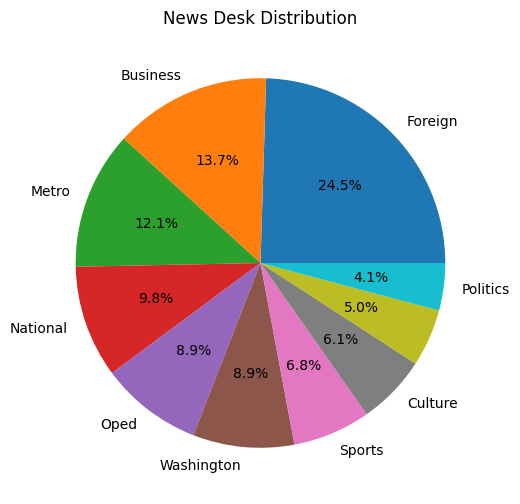

In [23]:
# make a pie chart of the news_desk column

# if the unique values in the news_desk column are less than 10, group them in the 'Other' category
news_desk_counts = df['news_desk'].value_counts()

if len(news_desk_counts) > 10:
    news_desk_counts['Other'] = news_desk_counts[10:].sum()
    news_desk_counts = news_desk_counts[:10]

plt.figure(figsize=(10, 6))
plt.pie(news_desk_counts, labels=news_desk_counts.index, autopct='%1.1f%%')
plt.title('News Desk Distribution')
plt.show()



Democratic Party                   560
Republican Party                   534
House Of Representatives           300
Senate                             201
Islamic State In Iraq And Syria    191
                                  ... 
Rooms Hotel                          1
Palazzo Ducale                       1
National Immigration Law Center      1
Black Eyed Peas                      1
Columbia Pictures                    1
Name: organization, Length: 3945, dtype: int64


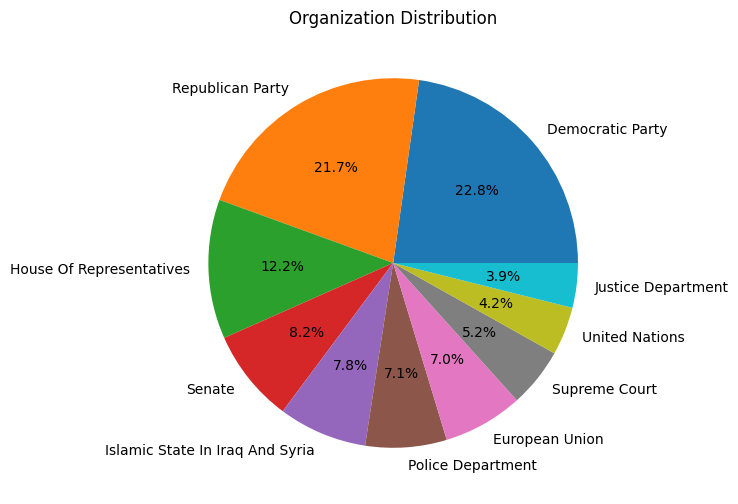

In [30]:
print(df['organization'].value_counts())

# if the unique values in the organization column are less 
# than 10, group them in the 'Other' category and show them 
# on the pie chart as other
organization_counts = df['organization'].value_counts()

if len(organization_counts) > 10:
    organization_counts['Other'] = organization_counts[10:].sum()
    organization_counts = organization_counts[:10]

plt.figure(figsize=(10, 6))
plt.pie(organization_counts, labels=organization_counts.index, autopct='%1.1f%%')
plt.title('Organization Distribution')
plt.show()

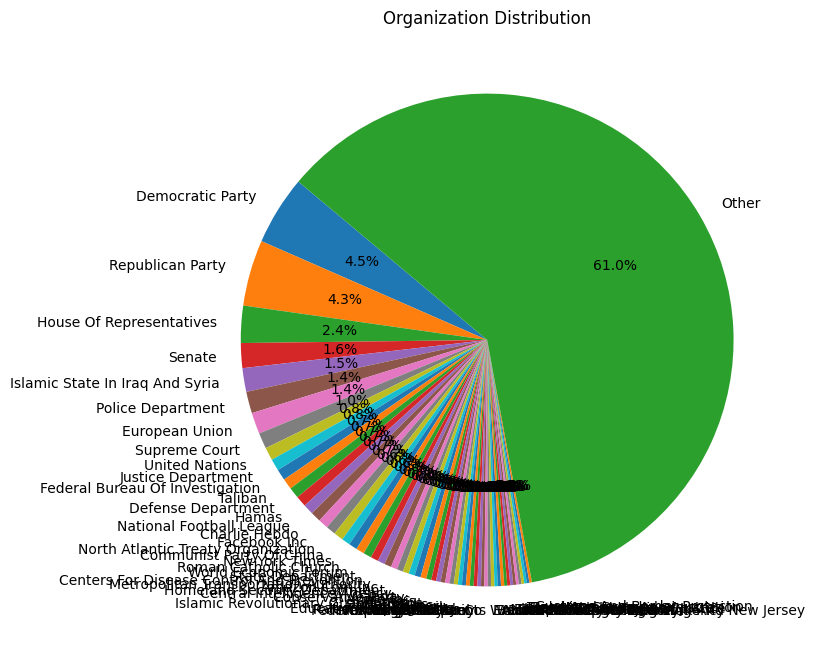

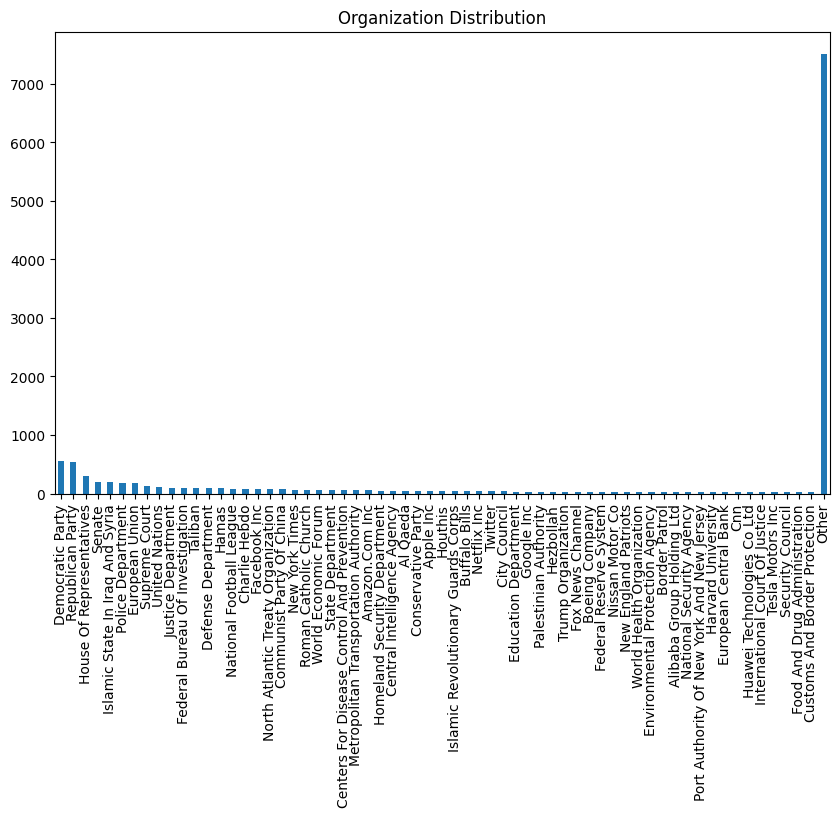

In [28]:
# Step 1: Count occurrences of each organization
organization_counts = df['organization'].value_counts()

# Step 2: Group organizations with less than 10 occurrences into 'Other'
threshold = 20
other_count = organization_counts[organization_counts < threshold].sum()
organization_counts = organization_counts[organization_counts >= threshold]
organization_counts['Other'] = other_count

# Step 3: Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(organization_counts, labels=organization_counts.index,
        autopct='%1.1f%%', startangle=140)
plt.title("Organization Distribution")
plt.show()

# make is a bar chart instead of a pie chart
plt.figure(figsize=(10, 6))
organization_counts.plot(kind='bar')
plt.title('Organization Distribution')
plt.show()

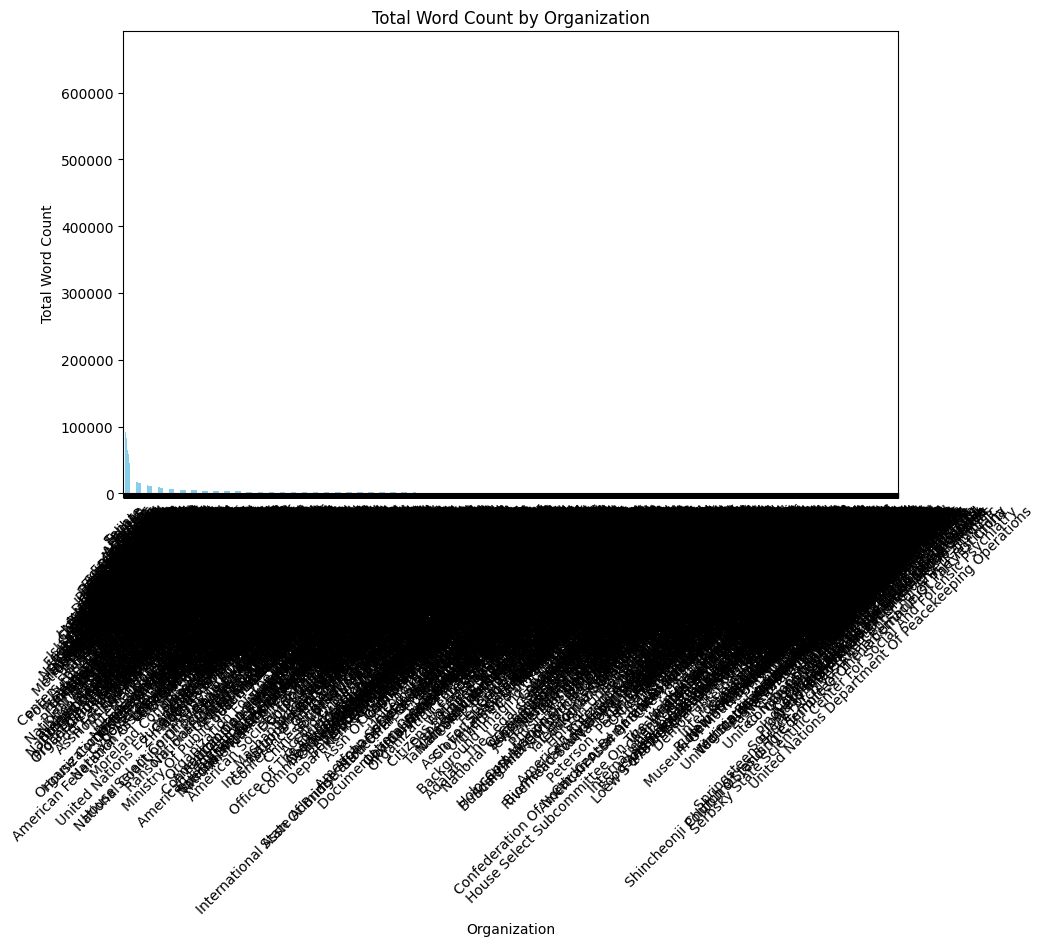

In [29]:
# which organization has the most word count
organization_word_counts = df.groupby('organization')['word_count'].sum()

# Step 2: Sort the data by word count in descending order
organization_word_counts = organization_word_counts.sort_values(
    ascending=False)

# Step 3: Plot the data
plt.figure(figsize=(10, 6))
organization_word_counts.plot(kind='bar', color='skyblue')
plt.title("Total Word Count by Organization")
plt.xlabel("Organization")
plt.ylabel("Total Word Count")
plt.xticks(rotation=45)
plt.show()

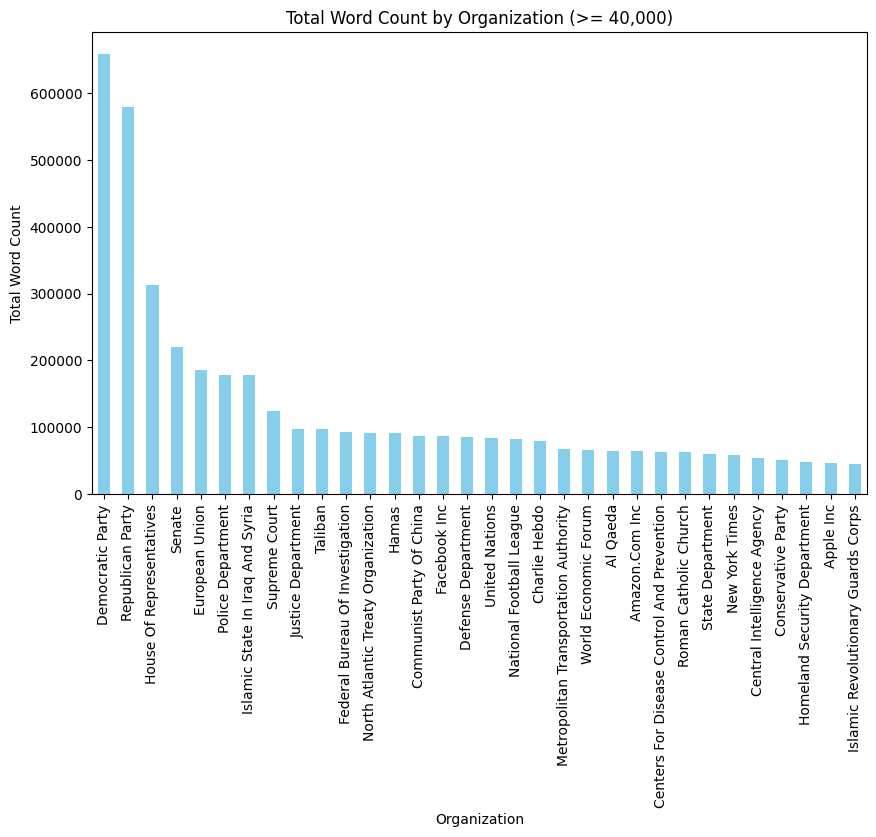

In [35]:
#Filter organizations with a total word count of 40,000 or more
organization_word_counts = organization_word_counts[organization_word_counts >= 40000]

organization_word_counts = organization_word_counts.sort_values(
    ascending=False)

plt.figure(figsize=(10, 6))
organization_word_counts.plot(kind='bar', color='skyblue')
plt.title("Total Word Count by Organization (>= 40,000)")
plt.xlabel("Organization")
plt.ylabel("Total Word Count")

plt.show()

In [36]:
print(df['author'].value_counts())

Michael              95
Choe Sang-Hun        80
James Barron         75
Chad Bray            75
Ken Belson           72
                     ..
Andrew                1
Judith Dobrzynski     1
Claire Barthelemy     1
Christine Quinn       1
Jessica Hester        1
Name: author, Length: 2415, dtype: int64


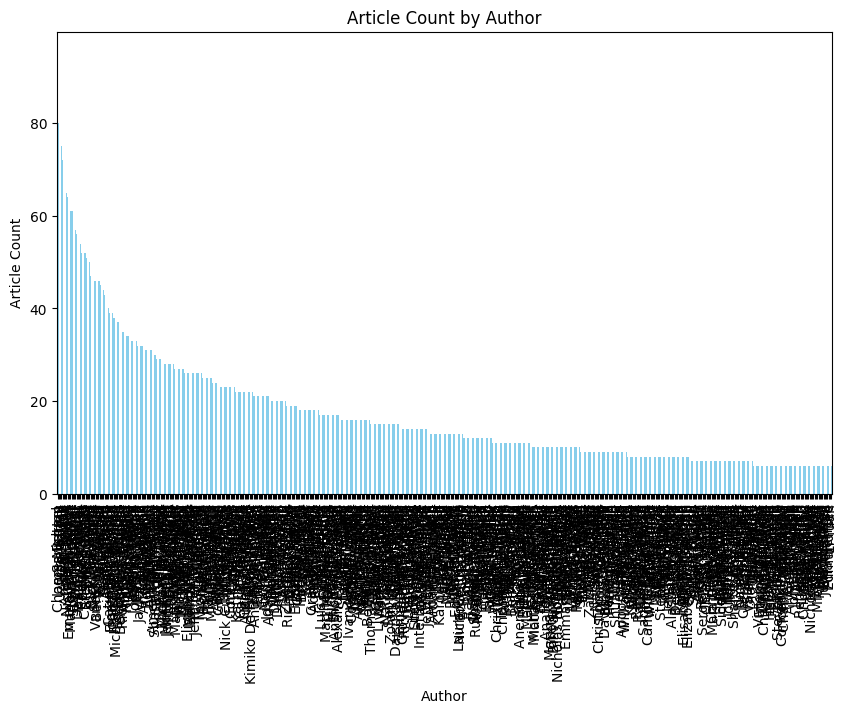

In [42]:
# who wrote the most articles
author_counts = df['author'].value_counts()


# drop all that have 1 or less articles to their name
author_counts = author_counts[author_counts > 5]

author_counts = author_counts.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
author_counts.plot(kind='bar', color='skyblue')
plt.title("Article Count by Author")
plt.xlabel("Author")
plt.ylabel("Article Count")
plt.show()

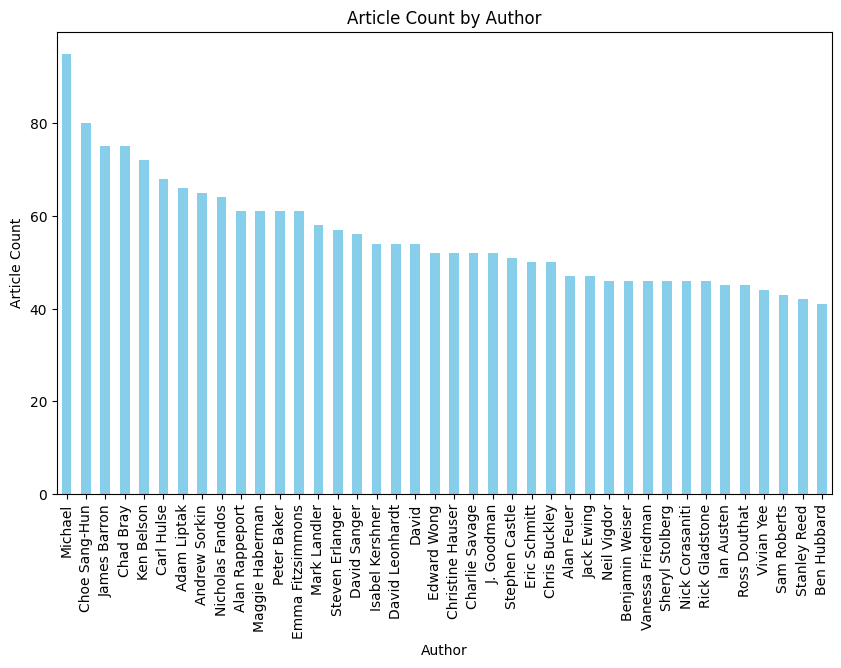

In [43]:
# who wrote the most articles
author_counts = df['author'].value_counts()


# drop all that have 1 or less articles to their name
author_counts = author_counts[author_counts > 40]

author_counts = author_counts.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
author_counts.plot(kind='bar', color='skyblue')
plt.title("Article Count by Author")
plt.xlabel("Author")
plt.ylabel("Article Count")
plt.show()